# Finetuning MLP Hyperparameters
Example script finetuning hyperparameters, we'll ue a *Baysian optimisation* method for efficiency and effectiveness. It samples hyperparameter space based on previous results. 

We use the ``Optuna`` library for this.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import *
from ssa_analysis import *
from ssa_classification import *
from models.MLP import MLP 
from utils.set_seed import set_seed
from utils.load_data import load_and_split_data
import optuna
%load_ext autoreload
%autoreload 2

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## An example

We use a small amount of data to train so this won't take long. In reality, this will take much longer, especially if the input data is large and if we use a grid search strategy.

In [2]:
# load and preprocess the data
output_file = 'data/mRNA_trajectories_example.csv'
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(output_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
# Standardize the data 
# If your input features are too large (e.g., >1000) or too small (<0.0001), it can cause unstable training, so it's better to standardize the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (256, 144)
y_train shape: (256,)


In [24]:
# Set seed for reproducibility
set_seed(42)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(
    'data/mRNA_trajectories_example.csv', split_val_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def objective(trial):
    hidden_size = [
        trial.suggest_categorical("hidden_size_1", [64, 128, 256]),
        trial.suggest_categorical("hidden_size_2", [32, 64, 128])
    ]
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.001, 0.0001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    epochs = trial.suggest_categorical("epochs", [10, 50, 100])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
        batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)),
        batch_size=batch_size, shuffle=False)

    model = MLP(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        output_size=len(set(y_train)),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        optimizer=optimizer_choice
    )

    history = model.train_model(train_loader, val_loader, epochs=epochs, patience=10)
    val_accuracy = model.evaluate(val_loader)

    return val_accuracy

# Run optimization study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Display the best hyperparameters
print(f"\nBest Validation Accuracy: {study.best_value:.4f}")
print("Best Hyperparameters:", study.best_params)


[I 2025-03-23 20:00:28,142] A new study created in memory with name: no-name-79360be5-fd82-4b9f-99d2-8ca55e2bc579


🔄 Using device: cuda (1 GPUs available)


[I 2025-03-23 20:00:29,105] Trial 0 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.38145306814141267, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.65625.


DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8652, Train Acc: 0.6562
Validation Acc: 0.6875
Epoch [2/50], Loss: 0.6165, Train Acc: 0.7812
Validation Acc: 0.7031
Epoch [3/50], Loss: 0.6301, Train Acc: 0.7695
Validation Acc: 0.7344
Epoch [4/50], Loss: 0.4935, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (1/10).
Epoch [5/50], Loss: 0.4386, Train Acc: 0.8242
Validation Acc: 0.6406
No improvement (2/10).
Epoch [6/50], Loss: 0.4703, Train Acc: 0.7734
Validation Acc: 0.6562
No improvement (3/10).
Epoch [7/50], Loss: 0.5090, Train Acc: 0.8008
Validation Acc: 0.6406
No improvement (4/10).
Epoch [8/50], Loss: 0.4437, Train Acc: 0.8047
Validation Acc: 0.7188
No improvement (5/10).
Epoch [9/50], Loss: 0.4678, Train Acc: 0.7734
Validation Acc: 0.7344
No improvement (6/10).
Epoch [10/50], Loss: 0.4410, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (7/10).
Epoch [11/50], Loss: 0.4094, Train Acc: 0.8438
Validation Acc: 0.6875
No improvement (8/10).
E

[I 2025-03-23 20:00:29,193] Trial 1 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.4432083005446278, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.71875.


Epoch [5/50], Loss: 1.2269, Train Acc: 0.4648
Validation Acc: 0.4531
No improvement (4/10).
Epoch [6/50], Loss: 0.8333, Train Acc: 0.5430
Validation Acc: 0.4531
No improvement (5/10).
Epoch [7/50], Loss: 1.1604, Train Acc: 0.5117
Validation Acc: 0.4688
Epoch [8/50], Loss: 1.1398, Train Acc: 0.5156
Validation Acc: 0.7031
Epoch [9/50], Loss: 1.1686, Train Acc: 0.5234
Validation Acc: 0.7031
No improvement (1/10).
Epoch [10/50], Loss: 1.1172, Train Acc: 0.5234
Validation Acc: 0.7031
No improvement (2/10).
Epoch [11/50], Loss: 1.0404, Train Acc: 0.5430
Validation Acc: 0.7188
Epoch [12/50], Loss: 0.9954, Train Acc: 0.5664
Validation Acc: 0.7188
No improvement (1/10).
Epoch [13/50], Loss: 1.0331, Train Acc: 0.5859
Validation Acc: 0.7188
No improvement (2/10).
Epoch [14/50], Loss: 1.0253, Train Acc: 0.5625
Validation Acc: 0.7188
No improvement (3/10).
Epoch [15/50], Loss: 0.9670, Train Acc: 0.5977
Validation Acc: 0.7188
No improvement (4/10).
Epoch [16/50], Loss: 1.0257, Train Acc: 0.5859
Vali

[I 2025-03-23 20:00:29,361] Trial 2 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.29773075813098515, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.71875.
[I 2025-03-23 20:00:29,495] Trial 3 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.35384099086978194, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.71875.


Epoch [20/100], Loss: 0.3983, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (8/10).
Epoch [21/100], Loss: 0.4068, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (9/10).
Epoch [22/100], Loss: 0.3788, Train Acc: 0.8320
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.1350, Train Acc: 0.5078
Validation Acc: 0.3281
Epoch [2/10], Loss: 0.9187, Train Acc: 0.5234
Validation Acc: 0.5781
Epoch [3/10], Loss: 0.8951, Train Acc: 0.5820
Validation Acc: 0.5781
No improvement (1/10).
Epoch [4/10], Loss: 0.9835, Train Acc: 0.5977
Validation Acc: 0.5781
No improvement (2/10).
Epoch [5/10], Loss: 0.7913, Train Acc: 0.6562
Validation Acc: 0.5781
No improvement (3/10).
Epoch [6/10], Loss: 0.7170, Train Acc: 0.6641
Validation Acc: 0.5938
Epoch [7/10], Loss: 0.7935, Train Acc: 0.6953
Validation Acc: 0.6094
Epoch 

[I 2025-03-23 20:00:29,549] Trial 4 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.35759613669270973, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.71875.
[I 2025-03-23 20:00:29,697] Trial 5 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.4596083909672527, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.71875.


Epoch [14/100], Loss: 0.5887, Train Acc: 0.7695
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.9813, Train Acc: 0.6133
Validation Acc: 0.6719
Epoch [2/50], Loss: 0.7172, Train Acc: 0.7070
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/50], Loss: 0.9869, Train Acc: 0.6758
Validation Acc: 0.6719
No improvement (2/10).
Epoch [4/50], Loss: 0.8830, Train Acc: 0.6953
Validation Acc: 0.6719
No improvement (3/10).
Epoch [5/50], Loss: 0.7945, Train Acc: 0.7148
Validation Acc: 0.6562
No improvement (4/10).
Epoch [6/50], Loss: 0.5582, Train Acc: 0.7383
Validation Acc: 0.6562
No improvement (5/10).
Epoch [7/50], Loss: 0.5304, Train Acc: 0.7578
Validation Acc: 0.6562
No improvement (6/10).
Epoch [8/50], Loss: 0.5834, Train Acc: 0.7461
Validation Acc: 0.6719
No improvement (7/10).
Epoch [9/50], Loss: 0.5958, Train

[I 2025-03-23 20:00:29,751] Trial 6 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.4635179693509742, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.71875.
[I 2025-03-23 20:00:29,901] Trial 7 finished with value: 0.640625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.44132755933801493, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.71875.


Epoch [11/100], Loss: 0.9839, Train Acc: 0.6836
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.5008, Train Acc: 0.4531
Validation Acc: 0.6250
Epoch [2/100], Loss: 0.6642, Train Acc: 0.7500
Validation Acc: 0.6719
Epoch [3/100], Loss: 0.6056, Train Acc: 0.7695
Validation Acc: 0.6562
No improvement (1/10).
Epoch [4/100], Loss: 0.5659, Train Acc: 0.7500
Validation Acc: 0.6719
No improvement (2/10).
Epoch [5/100], Loss: 0.5356, Train Acc: 0.7500
Validation Acc: 0.6562
No improvement (3/10).
Epoch [6/100], Loss: 0.4861, Train Acc: 0.7500
Validation Acc: 0.6562
No improvement (4/10).
Epoch [7/100], Loss: 0.5063, Train Acc: 0.7852
Validation Acc: 0.6562
No improvement (5/10).
Epoch [8/100], Loss: 0.4520, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (6/10).
Epoch [9/100], Loss: 0.4838, Train Acc: 0.7773
V

[I 2025-03-23 20:00:30,136] Trial 8 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.46148985825182964, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.71875.


Epoch [4/100], Loss: 0.5447, Train Acc: 0.7734
Validation Acc: 0.7031
No improvement (1/10).
Epoch [5/100], Loss: 0.5602, Train Acc: 0.7891
Validation Acc: 0.6875
No improvement (2/10).
Epoch [6/100], Loss: 0.4932, Train Acc: 0.7812
Validation Acc: 0.7031
No improvement (3/10).
Epoch [7/100], Loss: 0.4477, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (4/10).
Epoch [8/100], Loss: 0.4202, Train Acc: 0.8086
Validation Acc: 0.7188
Epoch [9/100], Loss: 0.4059, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (1/10).
Epoch [10/100], Loss: 0.4384, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (2/10).
Epoch [11/100], Loss: 0.4269, Train Acc: 0.8008
Validation Acc: 0.7031
No improvement (3/10).
Epoch [12/100], Loss: 0.3947, Train Acc: 0.8359
Validation Acc: 0.6875
No improvement (4/10).
Epoch [13/100], Loss: 0.4392, Train Acc: 0.7852
Validation Acc: 0.6406
No improvement (5/10).
Epoch [14/100], Loss: 0.4138, Train Acc: 0.8320
Validation Acc: 0.6094
No improvement (6/

[I 2025-03-23 20:00:30,228] Trial 9 finished with value: 0.59375 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.19001398570848724, 'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.71875.
[I 2025-03-23 20:00:30,271] Trial 10 finished with value: 0.390625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.11680199132076324, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.71875.


Validation Acc: 0.3125
No improvement (3/10).
Epoch [5/50], Loss: 1.1237, Train Acc: 0.4297
Validation Acc: 0.3125
No improvement (4/10).
Epoch [6/50], Loss: 1.0927, Train Acc: 0.4062
Validation Acc: 0.3125
No improvement (5/10).
Epoch [7/50], Loss: 1.1254, Train Acc: 0.4102
Validation Acc: 0.3125
No improvement (6/10).
Epoch [8/50], Loss: 1.2207, Train Acc: 0.4180
Validation Acc: 0.3125
No improvement (7/10).
Epoch [9/50], Loss: 1.2038, Train Acc: 0.4453
Validation Acc: 0.3125
No improvement (8/10).
Epoch [10/50], Loss: 1.1990, Train Acc: 0.4141
Validation Acc: 0.3125
No improvement (9/10).
Epoch [11/50], Loss: 1.1120, Train Acc: 0.4727
Validation Acc: 0.5625
Epoch [12/50], Loss: 1.2742, Train Acc: 0.4492
Validation Acc: 0.5625
No improvement (1/10).
Epoch [13/50], Loss: 1.1525, Train Acc: 0.4688
Validation Acc: 0.5625
No improvement (2/10).
Epoch [14/50], Loss: 1.0907, Train Acc: 0.4648
Validation Acc: 0.5781
Epoch [15/50], Loss: 1.1516, Train Acc: 0.4805
Validation Acc: 0.5938
Epoch

[I 2025-03-23 20:00:30,397] Trial 11 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.2557249322739462, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:30,553] Trial 12 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.2648696483094938, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [11/50], Loss: 0.3757, Train Acc: 0.8125
Validation Acc: 0.7500
No improvement (5/10).
Epoch [12/50], Loss: 0.4129, Train Acc: 0.7930
Validation Acc: 0.6875
No improvement (6/10).
Epoch [13/50], Loss: 0.4041, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (7/10).
Epoch [14/50], Loss: 0.4247, Train Acc: 0.8125
Validation Acc: 0.7344
No improvement (8/10).
Epoch [15/50], Loss: 0.4232, Train Acc: 0.7852
Validation Acc: 0.7344
No improvement (9/10).
Epoch [16/50], Loss: 0.3956, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.7945, Train Acc: 0.6523
Validation Acc: 0.6875
Epoch [2/50], Loss: 0.5703, Train Acc: 0.7422
Validation Acc: 0.7031
Epoch [3/50], Loss: 0.5757, Train Acc: 0.7500
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/50], Loss: 0.5175, Train Acc: 0.7891
Valida

[I 2025-03-23 20:00:30,680] Trial 13 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.22837070447431665, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.3831, Train Acc: 0.2969
Validation Acc: 0.3906
Epoch [2/50], Loss: 1.1542, Train Acc: 0.3984
Validation Acc: 0.3906
No improvement (1/10).
Epoch [3/50], Loss: 1.1049, Train Acc: 0.4766
Validation Acc: 0.6250
Epoch [4/50], Loss: 0.8239, Train Acc: 0.6172
Validation Acc: 0.6094
No improvement (1/10).
Epoch [5/50], Loss: 0.7358, Train Acc: 0.6602
Validation Acc: 0.6406
Epoch [6/50], Loss: 0.8176, Train Acc: 0.6484
Validation Acc: 0.6406
No improvement (1/10).
Epoch [7/50], Loss: 0.7108, Train Acc: 0.7188
Validation Acc: 0.6562
Epoch [8/50], Loss: 0.6758, Train Acc: 0.7109
Validation Acc: 0.6562
No improvement (1/10).
Epoch [9/50], Loss: 0.5947, Train Acc: 0.7578
Validation Acc: 0.6406
No improvement (2/10).
Epoch [10/50], Loss: 0.6489, Train Acc: 0.7227
Validation Acc: 0.6406
No improvement (3/10).
Epoch [11/50], Loss: 0.5188, Train Acc: 0.7578
Validation Acc: 0.6406
No impr

[I 2025-03-23 20:00:30,791] Trial 14 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.17090578147461713, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:30,879] Trial 15 finished with value: 0.640625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.3955738481349543, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:30,957] Trial 16 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.2908296672839971, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [11/50], Loss: 0.3934, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (7/10).
Epoch [12/50], Loss: 0.3965, Train Acc: 0.8086
Validation Acc: 0.6406
No improvement (8/10).
Epoch [13/50], Loss: 0.3849, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (9/10).
Epoch [14/50], Loss: 0.3942, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.7249, Train Acc: 0.4336
Validation Acc: 0.5625
Epoch [2/50], Loss: 1.5584, Train Acc: 0.4766
Validation Acc: 0.5469
No improvement (1/10).
Epoch [3/50], Loss: 1.2482, Train Acc: 0.5352
Validation Acc: 0.5469
No improvement (2/10).
Epoch [4/50], Loss: 1.2687, Train Acc: 0.5547
Validation Acc: 0.5781
Epoch [5/50], Loss: 1.3230, Train Acc: 0.5586
Validation Acc: 0.5625
No improvement (1/10).
Epoch [6/50], Loss: 1.1184, Train Acc: 0.5977
Validati

[I 2025-03-23 20:00:31,038] Trial 17 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.30817221213437934, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:31,117] Trial 18 finished with value: 0.4375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.24703321435244593, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [1/10], Loss: 1.1864, Train Acc: 0.3984
Validation Acc: 0.4375
Epoch [2/10], Loss: 1.0633, Train Acc: 0.4492
Validation Acc: 0.4531
Epoch [3/10], Loss: 0.9568, Train Acc: 0.5117
Validation Acc: 0.4531
No improvement (1/10).
Epoch [4/10], Loss: 0.9584, Train Acc: 0.5508
Validation Acc: 0.7188
Epoch [5/10], Loss: 0.7848, Train Acc: 0.5508
Validation Acc: 0.7188
No improvement (1/10).
Epoch [6/10], Loss: 0.8788, Train Acc: 0.6172
Validation Acc: 0.7188
No improvement (2/10).
Epoch [7/10], Loss: 0.8096, Train Acc: 0.6484
Validation Acc: 0.7188
No improvement (3/10).
Epoch [8/10], Loss: 0.8365, Train Acc: 0.6367
Validation Acc: 0.6562
No improvement (4/10).
Epoch [9/10], Loss: 0.8354, Train Acc: 0.6484
Validation Acc: 0.6719
No improvement (5/10).
Epoch [10/10], Loss: 0.8997, Train Acc: 0.6680
Validation Acc: 0.6719
No improvement (6/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.0783, Train A

[I 2025-03-23 20:00:31,201] Trial 19 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.3032922991384764, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:31,284] Trial 20 finished with value: 0.703125 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.194318929238171, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [7/10], Loss: 0.9727, Train Acc: 0.6445
Validation Acc: 0.6406
No improvement (4/10).
Epoch [8/10], Loss: 0.9382, Train Acc: 0.6602
Validation Acc: 0.6406
No improvement (5/10).
Epoch [9/10], Loss: 0.7787, Train Acc: 0.6914
Validation Acc: 0.6562
Epoch [10/10], Loss: 0.7174, Train Acc: 0.7188
Validation Acc: 0.6562
No improvement (1/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.0053, Train Acc: 0.4727
Validation Acc: 0.4531
Epoch [2/10], Loss: 1.0863, Train Acc: 0.4922
Validation Acc: 0.6875
Epoch [3/10], Loss: 0.9666, Train Acc: 0.5586
Validation Acc: 0.6875
No improvement (1/10).
Epoch [4/10], Loss: 0.9936, Train Acc: 0.6172
Validation Acc: 0.6875
No improvement (2/10).
Epoch [5/10], Loss: 0.8911, Train Acc: 0.6562
Validation Acc: 0.6875
No improvement (3/10).
Epoch [6/10], Loss: 0.9246, Train Acc: 0.6250
Validation Acc: 0.6875
No improvement (4/10).
Epoch [7/10], Loss: 0.8448, Train A

[I 2025-03-23 20:00:31,386] Trial 21 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.33133146024720483, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:31,537] Trial 22 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.40654415167055297, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [27/50], Loss: 0.7203, Train Acc: 0.7188
Validation Acc: 0.7188
No improvement (9/10).
Epoch [28/50], Loss: 0.6583, Train Acc: 0.6875
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.4839, Train Acc: 0.3984
Validation Acc: 0.4375
Epoch [2/50], Loss: 1.3738, Train Acc: 0.3633
Validation Acc: 0.4375
No improvement (1/10).
Epoch [3/50], Loss: 1.3463, Train Acc: 0.4062
Validation Acc: 0.4375
No improvement (2/10).
Epoch [4/50], Loss: 1.1105, Train Acc: 0.4570
Validation Acc: 0.3906
No improvement (3/10).
Epoch [5/50], Loss: 1.1771, Train Acc: 0.4375
Validation Acc: 0.3750
No improvement (4/10).
Epoch [6/50], Loss: 1.2147, Train Acc: 0.4688
Validation Acc: 0.3906
No improvement (5/10).
Epoch [7/50], Loss: 1.1611, Train Acc: 0.4609
Validation Acc: 0.3906
No improvement (6/10).
Epoch [8/50], Loss: 0.9552, Train

[I 2025-03-23 20:00:31,584] Trial 23 finished with value: 0.5625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.27765835870604416, 'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:31,659] Trial 24 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.21945143385632415, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [11/50], Loss: 0.9896, Train Acc: 0.5586
Validation Acc: 0.5625
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.2697, Train Acc: 0.3984
Validation Acc: 0.4375
Epoch [2/10], Loss: 1.1215, Train Acc: 0.4023
Validation Acc: 0.4375
No improvement (1/10).
Epoch [3/10], Loss: 0.9671, Train Acc: 0.4688
Validation Acc: 0.6875
Epoch [4/10], Loss: 0.9358, Train Acc: 0.5742
Validation Acc: 0.7031
Epoch [5/10], Loss: 0.7237, Train Acc: 0.7031
Validation Acc: 0.6250
No improvement (1/10).
Epoch [6/10], Loss: 0.8031, Train Acc: 0.6875
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/10], Loss: 0.7311, Train Acc: 0.6875
Validation Acc: 0.6719
No improvement (3/10).
Epoch [8/10], Loss: 0.6491, Train Acc: 0.7188
Validation Acc: 0.6875
No improvement (4/10).
Epoch [9/10], Loss: 0.5935, Train Acc: 0.7344
Validation Acc: 0.6875
No improvem

[I 2025-03-23 20:00:31,810] Trial 25 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.4861573128529109, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:31,852] Trial 26 finished with value: 0.515625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.13617760922997152, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:31,939] Trial 27 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.42232581259895763, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [18/50], Loss: 0.8584, Train Acc: 0.6719
Validation Acc: 0.6250
No improvement (7/10).
Epoch [19/50], Loss: 0.7757, Train Acc: 0.6484
Validation Acc: 0.6250
No improvement (8/10).
Epoch [20/50], Loss: 0.8316, Train Acc: 0.6992
Validation Acc: 0.6250
No improvement (9/10).
Epoch [21/50], Loss: 0.6846, Train Acc: 0.6680
Validation Acc: 0.6250
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 0.9898, Train Acc: 0.3750
Validation Acc: 0.4844
Epoch [2/10], Loss: 1.0143, Train Acc: 0.3477
Validation Acc: 0.4844
No improvement (1/10).
Epoch [3/10], Loss: 0.9185, Train Acc: 0.3867
Validation Acc: 0.4844
No improvement (2/10).
Epoch [4/10], Loss: 1.0135, Train Acc: 0.3594
Validation Acc: 0.4844
No improvement (3/10).
Epoch [5/10], Loss: 0.9660, Train Acc: 0.3867
Validation Acc: 0.5000
Epoch [6/10], Loss: 0.9378, Train Acc: 0.3477
Validati

[I 2025-03-23 20:00:32,034] Trial 28 finished with value: 0.6875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.3447831299737346, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:32,093] Trial 29 finished with value: 0.703125 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.3822751217210248, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:32,146] Trial 30 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.26927537179123207, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.


Epoch [6/50], Loss: 0.4472, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (4/10).
Epoch [7/50], Loss: 0.4416, Train Acc: 0.7852
Validation Acc: 0.6719
No improvement (5/10).
Epoch [8/50], Loss: 0.5050, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (6/10).
Epoch [9/50], Loss: 0.4213, Train Acc: 0.8242
Validation Acc: 0.6875
No improvement (7/10).
Epoch [10/50], Loss: 0.4792, Train Acc: 0.7930
Validation Acc: 0.6719
No improvement (8/10).
Epoch [11/50], Loss: 0.4296, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (9/10).
Epoch [12/50], Loss: 0.4311, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.3349, Train Acc: 0.3906
Validation Acc: 0.4844
Epoch [2/10], Loss: 1.2052, Train Acc: 0.3984
Validation Acc: 0.4844
No improvement (1/10).
Epoch [3/10], Loss: 1.1864, Trai

[I 2025-03-23 20:00:32,231] Trial 31 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.1930825685099766, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:32,312] Trial 32 finished with value: 0.59375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.22350898360661647, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:32,392] Trial 33 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.1572422057455184, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [5/10], Loss: 1.0321, Train Acc: 0.5938
Validation Acc: 0.6094
No improvement (3/10).
Epoch [6/10], Loss: 1.0447, Train Acc: 0.6328
Validation Acc: 0.6094
No improvement (4/10).
Epoch [7/10], Loss: 0.9703, Train Acc: 0.6328
Validation Acc: 0.6094
No improvement (5/10).
Epoch [8/10], Loss: 0.8918, Train Acc: 0.6484
Validation Acc: 0.6406
No improvement (6/10).
Epoch [9/10], Loss: 1.0421, Train Acc: 0.6094
Validation Acc: 0.6406
No improvement (7/10).
Epoch [10/10], Loss: 0.7771, Train Acc: 0.6562
Validation Acc: 0.6406
No improvement (8/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.1669, Train Acc: 0.5664
Validation Acc: 0.5625
Epoch [2/10], Loss: 1.1624, Train Acc: 0.5547
Validation Acc: 0.5625
No improvement (1/10).
Epoch [3/10], Loss: 1.2253, Train Acc: 0.5664
Validation Acc: 0.5625
No improvement (2/10).
Epoch [4/10], Loss: 1.1137, Train Acc: 0.6328
Validation Acc: 0.5938
Epoch [5/10]

[I 2025-03-23 20:00:32,476] Trial 34 finished with value: 0.59375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.3251360787053922, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:32,561] Trial 35 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.24837018948796147, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.4014, Train Acc: 0.3672
Validation Acc: 0.3438
Epoch [2/10], Loss: 1.6337, Train Acc: 0.3594
Validation Acc: 0.2969
No improvement (1/10).
Epoch [3/10], Loss: 1.3746, Train Acc: 0.4219
Validation Acc: 0.3281
No improvement (2/10).
Epoch [4/10], Loss: 1.2662, Train Acc: 0.4414
Validation Acc: 0.5625
Epoch [5/10], Loss: 1.1598, Train Acc: 0.4570
Validation Acc: 0.5625
No improvement (1/10).
Epoch [6/10], Loss: 1.3755, Train Acc: 0.5039
Validation Acc: 0.5781
Epoch [7/10], Loss: 1.2209, Train Acc: 0.5469
Validation Acc: 0.5781
No improvement (1/10).
Epoch [8/10], Loss: 1.0694, Train Acc: 0.5703
Validation Acc: 0.5781
No improvement (2/10).
Epoch [9/10], Loss: 1.1426, Train Acc: 0.5469
Validation Acc: 0.5781
No improvement (3/10).
Epoch [10/10], Loss: 1.0681, Train Acc: 0.5977
Validation Acc: 0.5938
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer i

[I 2025-03-23 20:00:32,754] Trial 36 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.20090830702463658, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [3/100], Loss: 0.4645, Train Acc: 0.7930
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/100], Loss: 0.4635, Train Acc: 0.7773
Validation Acc: 0.7188
Epoch [5/100], Loss: 0.4273, Train Acc: 0.7969
Validation Acc: 0.7188
No improvement (1/10).
Epoch [6/100], Loss: 0.4265, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (2/10).
Epoch [7/100], Loss: 0.4100, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (3/10).
Epoch [8/100], Loss: 0.3980, Train Acc: 0.8086
Validation Acc: 0.6406
No improvement (4/10).
Epoch [9/100], Loss: 0.4075, Train Acc: 0.8047
Validation Acc: 0.7188
No improvement (5/10).
Epoch [10/100], Loss: 0.4189, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (6/10).
Epoch [11/100], Loss: 0.4239, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (7/10).
Epoch [12/100], Loss: 0.3912, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (8/10).
Epoch [13/100], Loss: 0.4014, Train Acc: 0.8281
Validation Acc: 0.7031
No improvement (9/1

[I 2025-03-23 20:00:32,834] Trial 37 finished with value: 0.34375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.3592648118006939, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [7/10], Loss: 1.6588, Train Acc: 0.3945
Validation Acc: 0.3281
No improvement (6/10).
Epoch [8/10], Loss: 1.7222, Train Acc: 0.3945
Validation Acc: 0.3281
No improvement (7/10).
Epoch [9/10], Loss: 1.5478, Train Acc: 0.4648
Validation Acc: 0.3438
No improvement (8/10).
Epoch [10/10], Loss: 1.4747, Train Acc: 0.4375
Validation Acc: 0.3438
No improvement (9/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1227, Train Acc: 0.6250
Validation Acc: 0.6562
Epoch [2/100], Loss: 0.6689, Train Acc: 0.7656
Validation Acc: 0.6562
No improvement (1/10).
Epoch [3/100], Loss: 0.5909, Train Acc: 0.7422
Validation Acc: 0.6562
No improvement (2/10).
Epoch [4/100], Loss: 0.5067, Train Acc: 0.7695
Validation Acc: 0.7188
Epoch [5/100], Loss: 0.4425, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (1/10).
Epoch [6/100], Loss: 0.4407, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (2/10).
Epoch 

[I 2025-03-23 20:00:33,027] Trial 38 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.29199111567285774, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:33,202] Trial 39 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.2886989775964816, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [13/100], Loss: 0.3926, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (9/10).
Epoch [14/100], Loss: 0.3764, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.9916, Train Acc: 0.6133
Validation Acc: 0.7031
Epoch [2/100], Loss: 0.5943, Train Acc: 0.7578
Validation Acc: 0.6875
No improvement (1/10).
Epoch [3/100], Loss: 0.5357, Train Acc: 0.7734
Validation Acc: 0.6875
No improvement (2/10).
Epoch [4/100], Loss: 0.5021, Train Acc: 0.7812
Validation Acc: 0.7500
Epoch [5/100], Loss: 0.4362, Train Acc: 0.7812
Validation Acc: 0.7344
No improvement (1/10).
Epoch [6/100], Loss: 0.4562, Train Acc: 0.7969
Validation Acc: 0.7500
No improvement (2/10).
Epoch [7/100], Loss: 0.4527, Train Acc: 0.7812
Validation Acc: 0.7188
No improvement (3/10).
Epoch [8/100], Loss: 0.4536, Train Acc: 0.7969


[I 2025-03-23 20:00:33,530] Trial 40 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.3168870392552107, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [18/100], Loss: 0.3862, Train Acc: 0.8125
Validation Acc: 0.6719
No improvement (2/10).
Epoch [19/100], Loss: 0.3953, Train Acc: 0.8242
Validation Acc: 0.6719
No improvement (3/10).
Epoch [20/100], Loss: 0.4003, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (4/10).
Epoch [21/100], Loss: 0.4063, Train Acc: 0.8242
Validation Acc: 0.7031
No improvement (5/10).
Epoch [22/100], Loss: 0.3948, Train Acc: 0.8203
Validation Acc: 0.6562
No improvement (6/10).
Epoch [23/100], Loss: 0.3814, Train Acc: 0.8203
Validation Acc: 0.6406
No improvement (7/10).
Epoch [24/100], Loss: 0.3828, Train Acc: 0.8398
Validation Acc: 0.6406
No improvement (8/10).
Epoch [25/100], Loss: 0.3662, Train Acc: 0.8398
Validation Acc: 0.6562
No improvement (9/10).
Epoch [26/100], Loss: 0.3955, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on 

[I 2025-03-23 20:00:33,686] Trial 41 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.31876576325962674, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [8/100], Loss: 0.4247, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (6/10).
Epoch [9/100], Loss: 0.4101, Train Acc: 0.8203
Validation Acc: 0.6562
No improvement (7/10).
Epoch [10/100], Loss: 0.3912, Train Acc: 0.8320
Validation Acc: 0.6875
No improvement (8/10).
Epoch [11/100], Loss: 0.3951, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (9/10).
Epoch [12/100], Loss: 0.4139, Train Acc: 0.8164
Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1036, Train Acc: 0.6562
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.7632, Train Acc: 0.7500
Validation Acc: 0.7344
Epoch [3/100], Loss: 0.8079, Train Acc: 0.7148
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/100], Loss: 0.5453, Train Acc: 0.7695
Validation Acc: 0.6719
No improvement (2/10).
Epoch [5/100], Loss: 0.6563, Train Acc: 0.7109

[I 2025-03-23 20:00:33,880] Trial 42 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.499399503763996, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [9/100], Loss: 0.5095, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (7/10).
Epoch [10/100], Loss: 0.5099, Train Acc: 0.7930
Validation Acc: 0.7188
No improvement (8/10).
Epoch [11/100], Loss: 0.5072, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (9/10).
Epoch [12/100], Loss: 0.4743, Train Acc: 0.7734
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.0284, Train Acc: 0.6406
Validation Acc: 0.6406
Epoch [2/100], Loss: 0.6093, Train Acc: 0.7852
Validation Acc: 0.7188
Epoch [3/100], Loss: 0.5040, Train Acc: 0.7773
Validation Acc: 0.6562
No improvement (1/10).
Epoch [4/100], Loss: 0.4903, Train Acc: 0.7891
Validation Acc: 0.6406
No improvement (2/10).
Epoch [5/100], Loss: 0.4588, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (3/10).
Epoch [6/100], Loss: 0.4645, Train Acc: 0.7578

[I 2025-03-23 20:00:34,045] Trial 43 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.28942369857046557, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:34,221] Trial 44 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.24757774617310727, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [12/100], Loss: 0.3847, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.9568, Train Acc: 0.6367
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.5957, Train Acc: 0.7656
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/100], Loss: 0.4822, Train Acc: 0.7852
Validation Acc: 0.7344
Epoch [4/100], Loss: 0.4497, Train Acc: 0.7930
Validation Acc: 0.6719
No improvement (1/10).
Epoch [5/100], Loss: 0.3980, Train Acc: 0.8359
Validation Acc: 0.7344
No improvement (2/10).
Epoch [6/100], Loss: 0.4270, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (3/10).
Epoch [7/100], Loss: 0.4026, Train Acc: 0.8164
Validation Acc: 0.6406
No improvement (4/10).
Epoch [8/100], Loss: 0.3940, Train Acc: 0.8164
Validation Acc: 0.6406
No improvement (5/10).
Epoch [9/100], Loss: 0.4226, Train Acc: 0.8203
V

[I 2025-03-23 20:00:34,409] Trial 45 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.36969159960683, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [2/100], Loss: 0.7243, Train Acc: 0.7383
Validation Acc: 0.6719
Epoch [3/100], Loss: 0.5170, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/100], Loss: 0.5655, Train Acc: 0.7773
Validation Acc: 0.7500
Epoch [5/100], Loss: 0.4816, Train Acc: 0.7773
Validation Acc: 0.7031
No improvement (1/10).
Epoch [6/100], Loss: 0.4800, Train Acc: 0.7891
Validation Acc: 0.7344
No improvement (2/10).
Epoch [7/100], Loss: 0.4457, Train Acc: 0.8086
Validation Acc: 0.7031
No improvement (3/10).
Epoch [8/100], Loss: 0.4027, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (4/10).
Epoch [9/100], Loss: 0.4698, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (5/10).
Epoch [10/100], Loss: 0.4088, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (6/10).
Epoch [11/100], Loss: 0.4061, Train Acc: 0.8242
Validation Acc: 0.7344
No improvement (7/10).
Epoch [12/100], Loss: 0.4761, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (8/10).
Epoch [13/100], Loss

[I 2025-03-23 20:00:34,623] Trial 46 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.3673494948491743, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [4/100], Loss: 0.4968, Train Acc: 0.7930
Validation Acc: 0.7031
No improvement (1/10).
Epoch [5/100], Loss: 0.4873, Train Acc: 0.7773
Validation Acc: 0.7188
Epoch [6/100], Loss: 0.4562, Train Acc: 0.7969
Validation Acc: 0.7344
Epoch [7/100], Loss: 0.4831, Train Acc: 0.7812
Validation Acc: 0.7500
Epoch [8/100], Loss: 0.4366, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (1/10).
Epoch [9/100], Loss: 0.4341, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (2/10).
Epoch [10/100], Loss: 0.4774, Train Acc: 0.7695
Validation Acc: 0.6719
No improvement (3/10).
Epoch [11/100], Loss: 0.4457, Train Acc: 0.7930
Validation Acc: 0.7500
No improvement (4/10).
Epoch [12/100], Loss: 0.4533, Train Acc: 0.7891
Validation Acc: 0.6875
No improvement (5/10).
Epoch [13/100], Loss: 0.4249, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (6/10).
Epoch [14/100], Loss: 0.4165, Train Acc: 0.8203
Validation Acc: 0.6875
No improvement (7/10).
Epoch [15/100], Loss: 0.4385, Train Acc: 

[I 2025-03-23 20:00:34,764] Trial 47 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.4368339322353764, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [3/100], Loss: 0.6007, Train Acc: 0.7656
Validation Acc: 0.6875
No improvement (2/10).
Epoch [4/100], Loss: 0.6419, Train Acc: 0.7305
Validation Acc: 0.7031
No improvement (3/10).
Epoch [5/100], Loss: 0.5502, Train Acc: 0.7773
Validation Acc: 0.7188
No improvement (4/10).
Epoch [6/100], Loss: 0.5052, Train Acc: 0.7891
Validation Acc: 0.6562
No improvement (5/10).
Epoch [7/100], Loss: 0.4868, Train Acc: 0.8125
Validation Acc: 0.6406
No improvement (6/10).
Epoch [8/100], Loss: 0.4977, Train Acc: 0.7695
Validation Acc: 0.6406
No improvement (7/10).
Epoch [9/100], Loss: 0.4574, Train Acc: 0.8125
Validation Acc: 0.6406
No improvement (8/10).
Epoch [10/100], Loss: 0.5047, Train Acc: 0.7695
Validation Acc: 0.6250
No improvement (9/10).
Epoch [11/100], Loss: 0.4355, Train Acc: 0.7930
Validation Acc: 0.6250
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
E

[I 2025-03-23 20:00:34,894] Trial 48 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.3755840440201448, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Validation Acc: 0.6875
No improvement (2/10).
Epoch [28/100], Loss: 0.6636, Train Acc: 0.7148
Validation Acc: 0.6875
No improvement (3/10).
Epoch [29/100], Loss: 0.6709, Train Acc: 0.7188
Validation Acc: 0.6875
No improvement (4/10).
Epoch [30/100], Loss: 0.7212, Train Acc: 0.7227
Validation Acc: 0.6875
No improvement (5/10).
Epoch [31/100], Loss: 0.6841, Train Acc: 0.7227
Validation Acc: 0.6875
No improvement (6/10).
Epoch [32/100], Loss: 0.7566, Train Acc: 0.7188
Validation Acc: 0.6875
No improvement (7/10).
Epoch [33/100], Loss: 0.6975, Train Acc: 0.7188
Validation Acc: 0.6875
No improvement (8/10).
Epoch [34/100], Loss: 0.7406, Train Acc: 0.7070
Validation Acc: 0.6875
No improvement (9/10).
Epoch [35/100], Loss: 0.7244, Train Acc: 0.7070
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.3614, Train Acc: 0.4

[I 2025-03-23 20:00:35,183] Trial 49 finished with value: 0.703125 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.3711664473824819, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:35,235] Trial 50 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.4054333217477548, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [14/50], Loss: 0.5693, Train Acc: 0.7695
Validation Acc: 0.7031
No improvement (1/10).
Epoch [15/50], Loss: 0.6564, Train Acc: 0.7461
Validation Acc: 0.7031
No improvement (2/10).
Epoch [16/50], Loss: 0.5485, Train Acc: 0.7383
Validation Acc: 0.7031
No improvement (3/10).
Epoch [17/50], Loss: 0.5866, Train Acc: 0.7227
Validation Acc: 0.7031
No improvement (4/10).
Epoch [18/50], Loss: 0.5549, Train Acc: 0.7617
Validation Acc: 0.7031
No improvement (5/10).
Epoch [19/50], Loss: 0.5922, Train Acc: 0.7383
Validation Acc: 0.7031
No improvement (6/10).
Epoch [20/50], Loss: 0.5129, Train Acc: 0.7852
Validation Acc: 0.7031
No improvement (7/10).
Epoch [21/50], Loss: 0.5605, Train Acc: 0.7617
Validation Acc: 0.7031
No improvement (8/10).
Epoch [22/50], Loss: 0.4813, Train Acc: 0.7852
Validation Acc: 0.7031
No improvement (9/10).
Epoch [23/50], Loss: 0.4849, Train Acc: 0.7617
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Us

[I 2025-03-23 20:00:35,439] Trial 51 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.34804451581294277, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.


Epoch [3/100], Loss: 0.5852, Train Acc: 0.7773
Validation Acc: 0.6562
No improvement (1/10).
Epoch [4/100], Loss: 0.5332, Train Acc: 0.7695
Validation Acc: 0.6562
No improvement (2/10).
Epoch [5/100], Loss: 0.4975, Train Acc: 0.7930
Validation Acc: 0.7031
Epoch [6/100], Loss: 0.5199, Train Acc: 0.8164
Validation Acc: 0.6562
No improvement (1/10).
Epoch [7/100], Loss: 0.4113, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (2/10).
Epoch [8/100], Loss: 0.4140, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (3/10).
Epoch [9/100], Loss: 0.4524, Train Acc: 0.7891
Validation Acc: 0.6562
No improvement (4/10).
Epoch [10/100], Loss: 0.4393, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (5/10).
Epoch [11/100], Loss: 0.4258, Train Acc: 0.7812
Validation Acc: 0.6562
No improvement (6/10).
Epoch [12/100], Loss: 0.4128, Train Acc: 0.8281
Validation Acc: 0.6875
No improvement (7/10).
Epoch [13/100], Loss: 0.3910, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (8/1

[I 2025-03-23 20:00:35,676] Trial 52 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.44344217570699945, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Validation Acc: 0.6562
No improvement (2/10).
Epoch [4/100], Loss: 0.5895, Train Acc: 0.7422
Validation Acc: 0.6562
No improvement (3/10).
Epoch [5/100], Loss: 0.5195, Train Acc: 0.7734
Validation Acc: 0.6562
No improvement (4/10).
Epoch [6/100], Loss: 0.5640, Train Acc: 0.7812
Validation Acc: 0.6562
No improvement (5/10).
Epoch [7/100], Loss: 0.5046, Train Acc: 0.7695
Validation Acc: 0.6562
No improvement (6/10).
Epoch [8/100], Loss: 0.4933, Train Acc: 0.8164
Validation Acc: 0.6719
Epoch [9/100], Loss: 0.5097, Train Acc: 0.7852
Validation Acc: 0.7344
Epoch [10/100], Loss: 0.4337, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (1/10).
Epoch [11/100], Loss: 0.4403, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (2/10).
Epoch [12/100], Loss: 0.4667, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (3/10).
Epoch [13/100], Loss: 0.4478, Train Acc: 0.8047
Validation Acc: 0.6719
No improvement (4/10).
Epoch [14/100], Loss: 0.4445, Train Acc: 0.7969
Validation Acc: 0.

[I 2025-03-23 20:00:35,878] Trial 53 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.33682490456930414, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [1/100], Loss: 0.9661, Train Acc: 0.6914
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.6292, Train Acc: 0.7422
Validation Acc: 0.6875
Epoch [3/100], Loss: 0.5186, Train Acc: 0.7969
Validation Acc: 0.7188
Epoch [4/100], Loss: 0.5404, Train Acc: 0.7578
Validation Acc: 0.7031
No improvement (1/10).
Epoch [5/100], Loss: 0.4488, Train Acc: 0.7812
Validation Acc: 0.7500
Epoch [6/100], Loss: 0.4207, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (1/10).
Epoch [7/100], Loss: 0.4618, Train Acc: 0.8008
Validation Acc: 0.6875
No improvement (2/10).
Epoch [8/100], Loss: 0.4595, Train Acc: 0.7539
Validation Acc: 0.6719
No improvement (3/10).
Epoch [9/100], Loss: 0.4136, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (4/10).
Epoch [10/100], Loss: 0.4089, Train Acc: 0.8008
Validation Acc: 0.6875
No improvement (5/10).
Epoch [11/100], Loss: 0.4082, Train Acc: 0.8242
Validation Acc: 0.6719
No improvement (6/10).
Epoch [12/100], Loss: 0.3925, Train Acc: 0.8125
Validation Acc: 0.7

[I 2025-03-23 20:00:36,127] Trial 54 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.261460190422962, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:36,227] Trial 55 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.2548890016145141, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [18/100], Loss: 0.4202, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (8/10).
Epoch [19/100], Loss: 0.3969, Train Acc: 0.8281
Validation Acc: 0.6719
No improvement (9/10).
Epoch [20/100], Loss: 0.3930, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1668, Train Acc: 0.4766
Validation Acc: 0.5625
Epoch [2/100], Loss: 1.0994, Train Acc: 0.4844
Validation Acc: 0.5938
Epoch [3/100], Loss: 1.1128, Train Acc: 0.5391
Validation Acc: 0.5312
No improvement (1/10).
Epoch [4/100], Loss: 1.0360, Train Acc: 0.5117
Validation Acc: 0.5312
No improvement (2/10).
Epoch [5/100], Loss: 1.0418, Train Acc: 0.5664
Validation Acc: 0.5469
No improvement (3/10).
Epoch [6/100], Loss: 0.8618, Train Acc: 0.5820
Validation Acc: 0.5625
No improvement (4/10).
Epoch [7/100], Loss: 0.7453, Train Acc: 0.6484

[I 2025-03-23 20:00:36,499] Trial 56 finished with value: 0.6875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.23365482424983414, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [6/50], Loss: 0.4426, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (3/10).
Epoch [7/50], Loss: 0.4185, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (4/10).
Epoch [8/50], Loss: 0.4206, Train Acc: 0.7891
Validation Acc: 0.7031
Epoch [9/50], Loss: 0.4227, Train Acc: 0.8281
Validation Acc: 0.7188
Epoch [10/50], Loss: 0.4044, Train Acc: 0.7930
Validation Acc: 0.7031
No improvement (1/10).
Epoch [11/50], Loss: 0.3875, Train Acc: 0.8203
Validation Acc: 0.6875
No improvement (2/10).
Epoch [12/50], Loss: 0.4076, Train Acc: 0.7930
Validation Acc: 0.7500
Epoch [13/50], Loss: 0.4010, Train Acc: 0.8125
Validation Acc: 0.7500
No improvement (1/10).
Epoch [14/50], Loss: 0.3935, Train Acc: 0.8203
Validation Acc: 0.7500
No improvement (2/10).
Epoch [15/50], Loss: 0.4052, Train Acc: 0.8047
Validation Acc: 0.6875
No improvement (3/10).
Epoch [16/50], Loss: 0.3810, Train Acc: 0.8320
Validation Acc: 0.6875
No improvement (4/10).
Epoch [17/50], Loss: 0.3860, Train Acc: 0.8164
Val

[I 2025-03-23 20:00:36,544] Trial 57 finished with value: 0.359375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.27101803697318877, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [1/100], Loss: 1.4003, Train Acc: 0.3516
Validation Acc: 0.3750
Epoch [2/100], Loss: 1.5276, Train Acc: 0.3164
Validation Acc: 0.3750
No improvement (1/10).
Epoch [3/100], Loss: 1.4411, Train Acc: 0.3477
Validation Acc: 0.3594
No improvement (2/10).
Epoch [4/100], Loss: 1.5020, Train Acc: 0.3047
Validation Acc: 0.3594
No improvement (3/10).
Epoch [5/100], Loss: 1.4476, Train Acc: 0.3281
Validation Acc: 0.3594
No improvement (4/10).
Epoch [6/100], Loss: 1.2704, Train Acc: 0.3594
Validation Acc: 0.3594
No improvement (5/10).
Epoch [7/100], Loss: 1.3053, Train Acc: 0.3398
Validation Acc: 0.3594
No improvement (6/10).
Epoch [8/100], Loss: 1.4169, Train Acc: 0.3242
Validation Acc: 0.3438
No improvement (7/10).
Epoch [9/100], Loss: 1.2756, Train Acc: 0.3320
Validation Acc: 0.3594
No improvement (8/10).
Epoch [10/100], Loss: 1.2496, Train Acc: 0.3633
Validation Acc: 0.3594
No improvement (9/10).
Epoch [11/100], Loss: 1.1709, Train Acc: 0.4102
Validation Acc: 0.3594
No improvement (10/10

[I 2025-03-23 20:00:36,899] Trial 58 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.4789756521129507, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [14/50], Loss: 0.6090, Train Acc: 0.7461
Validation Acc: 0.6719
No improvement (4/10).
Epoch [15/50], Loss: 0.6666, Train Acc: 0.7031
Validation Acc: 0.6719
No improvement (5/10).
Epoch [16/50], Loss: 0.5836, Train Acc: 0.7227
Validation Acc: 0.6719
No improvement (6/10).
Epoch [17/50], Loss: 0.5768, Train Acc: 0.7461
Validation Acc: 0.6719
No improvement (7/10).
Epoch [18/50], Loss: 0.6104, Train Acc: 0.7344
Validation Acc: 0.6719
No improvement (8/10).
Epoch [19/50], Loss: 0.6477, Train Acc: 0.7148
Validation Acc: 0.6875
Epoch [20/50], Loss: 0.5934, Train Acc: 0.7344
Validation Acc: 0.6875
No improvement (1/10).
Epoch [21/50], Loss: 0.5937, Train Acc: 0.7305
Validation Acc: 0.6719
No improvement (2/10).
Epoch [22/50], Loss: 0.5761, Train Acc: 0.7578
Validation Acc: 0.6562
No improvement (3/10).
Epoch [23/50], Loss: 0.5715, Train Acc: 0.7422
Validation Acc: 0.6562
No improvement (4/10).
Epoch [24/50], Loss: 0.5622, Train Acc: 0.7383
Validation Acc: 0.6406
No improvement (5/10).


[I 2025-03-23 20:00:36,959] Trial 59 finished with value: 0.71875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.30530579315866796, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:37,070] Trial 60 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.38832620713947924, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [4/100], Loss: 0.6679, Train Acc: 0.6953
Validation Acc: 0.7188
Epoch [5/100], Loss: 0.6987, Train Acc: 0.6953
Validation Acc: 0.7344
Epoch [6/100], Loss: 0.6301, Train Acc: 0.7266
Validation Acc: 0.7344
No improvement (1/10).
Epoch [7/100], Loss: 0.6738, Train Acc: 0.7266
Validation Acc: 0.7344
No improvement (2/10).
Epoch [8/100], Loss: 0.6733, Train Acc: 0.7266
Validation Acc: 0.7344
No improvement (3/10).
Epoch [9/100], Loss: 0.5429, Train Acc: 0.7852
Validation Acc: 0.7344
No improvement (4/10).
Epoch [10/100], Loss: 0.5879, Train Acc: 0.7500
Validation Acc: 0.7344
No improvement (5/10).
Epoch [11/100], Loss: 0.5083, Train Acc: 0.7617
Validation Acc: 0.7344
No improvement (6/10).
Epoch [12/100], Loss: 0.5975, Train Acc: 0.7617
Validation Acc: 0.7344
No improvement (7/10).
Epoch [13/100], Loss: 0.5636, Train Acc: 0.7617
Validation Acc: 0.7344
No improvement (8/10).
Epoch [14/100], Loss: 0.5029, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (9/10).
Epoch [15/100], Lo

[I 2025-03-23 20:00:37,247] Trial 61 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.29380094899100495, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [4/100], Loss: 0.5549, Train Acc: 0.7969
Validation Acc: 0.7188
No improvement (1/10).
Epoch [5/100], Loss: 0.4647, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (2/10).
Epoch [6/100], Loss: 0.5064, Train Acc: 0.7578
Validation Acc: 0.6562
No improvement (3/10).
Epoch [7/100], Loss: 0.4639, Train Acc: 0.7969
Validation Acc: 0.7188
No improvement (4/10).
Epoch [8/100], Loss: 0.4338, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (5/10).
Epoch [9/100], Loss: 0.4071, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (6/10).
Epoch [10/100], Loss: 0.3899, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (7/10).
Epoch [11/100], Loss: 0.4009, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (8/10).
Epoch [12/100], Loss: 0.3856, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (9/10).
Epoch [13/100], Loss: 0.4236, Train Acc: 0.8359
Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!


[I 2025-03-23 20:00:37,437] Trial 62 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.2606344828705836, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.


Epoch [6/100], Loss: 0.4501, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (2/10).
Epoch [7/100], Loss: 0.4339, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (3/10).
Epoch [8/100], Loss: 0.4164, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (4/10).
Epoch [9/100], Loss: 0.3926, Train Acc: 0.8125
Validation Acc: 0.6406
No improvement (5/10).
Epoch [10/100], Loss: 0.3807, Train Acc: 0.8164
Validation Acc: 0.6406
No improvement (6/10).
Epoch [11/100], Loss: 0.3974, Train Acc: 0.8438
Validation Acc: 0.7031
No improvement (7/10).
Epoch [12/100], Loss: 0.3997, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (8/10).
Epoch [13/100], Loss: 0.4090, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (9/10).
Epoch [14/100], Loss: 0.4084, Train Acc: 0.8164
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA

[I 2025-03-23 20:00:37,721] Trial 63 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.2800795017543597, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [8/100], Loss: 0.4199, Train Acc: 0.8125
Validation Acc: 0.6719
No improvement (3/10).
Epoch [9/100], Loss: 0.3993, Train Acc: 0.8047
Validation Acc: 0.6719
No improvement (4/10).
Epoch [10/100], Loss: 0.4192, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (5/10).
Epoch [11/100], Loss: 0.4237, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (6/10).
Epoch [12/100], Loss: 0.3882, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (7/10).
Epoch [13/100], Loss: 0.4187, Train Acc: 0.8125
Validation Acc: 0.7188
Epoch [14/100], Loss: 0.3789, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (1/10).
Epoch [15/100], Loss: 0.3866, Train Acc: 0.8398
Validation Acc: 0.6562
No improvement (2/10).
Epoch [16/100], Loss: 0.4012, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (3/10).
Epoch [17/100], Loss: 0.3968, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (4/10).
Epoch [18/100], Loss: 0.4299, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement

[I 2025-03-23 20:00:37,874] Trial 64 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.36225682052280406, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [1/100], Loss: 1.0871, Train Acc: 0.6523
Validation Acc: 0.7656
Epoch [2/100], Loss: 0.7659, Train Acc: 0.7266
Validation Acc: 0.7031
No improvement (1/10).
Epoch [3/100], Loss: 0.6080, Train Acc: 0.7656
Validation Acc: 0.6406
No improvement (2/10).
Epoch [4/100], Loss: 0.5116, Train Acc: 0.7891
Validation Acc: 0.7344
No improvement (3/10).
Epoch [5/100], Loss: 0.4696, Train Acc: 0.7891
Validation Acc: 0.6719
No improvement (4/10).
Epoch [6/100], Loss: 0.3942, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (5/10).
Epoch [7/100], Loss: 0.4479, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (6/10).
Epoch [8/100], Loss: 0.4097, Train Acc: 0.8242
Validation Acc: 0.6875
No improvement (7/10).
Epoch [9/100], Loss: 0.4049, Train Acc: 0.8164
Validation Acc: 0.7188
No improvement (8/10).
Epoch [10/100], Loss: 0.4038, Train Acc: 0.8047
Validation Acc: 0.6875
No improvement (9/10).
Epoch [11/100], Loss: 0.4458, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (10/10

[I 2025-03-23 20:00:38,015] Trial 65 finished with value: 0.703125 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.21164248312790893, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [9/50], Loss: 0.4277, Train Acc: 0.8203
Validation Acc: 0.7812
Epoch [10/50], Loss: 0.4498, Train Acc: 0.7969
Validation Acc: 0.7812
No improvement (1/10).
Epoch [11/50], Loss: 0.4164, Train Acc: 0.8086
Validation Acc: 0.7656
No improvement (2/10).
Epoch [12/50], Loss: 0.4211, Train Acc: 0.8008
Validation Acc: 0.7812
No improvement (3/10).
Epoch [13/50], Loss: 0.4201, Train Acc: 0.8008
Validation Acc: 0.7812
No improvement (4/10).
Epoch [14/50], Loss: 0.4085, Train Acc: 0.8164
Validation Acc: 0.7812
No improvement (5/10).
Epoch [15/50], Loss: 0.4226, Train Acc: 0.8125
Validation Acc: 0.7812
No improvement (6/10).
Epoch [16/50], Loss: 0.4105, Train Acc: 0.8125
Validation Acc: 0.7812
No improvement (7/10).
Epoch [17/50], Loss: 0.4234, Train Acc: 0.8008
Validation Acc: 0.7812
No improvement (8/10).
Epoch [18/50], Loss: 0.4108, Train Acc: 0.8047
Validation Acc: 0.7812
No improvement (9/10).
Epoch [19/50], Loss: 0.4034, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (10/10).


[I 2025-03-23 20:00:38,222] Trial 66 finished with value: 0.5 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.4106613285613337, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:38,314] Trial 67 finished with value: 0.6875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.2331086010399061, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


Epoch [10/100], Loss: 0.4140, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (5/10).
Epoch [11/100], Loss: 0.4173, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (6/10).
Epoch [12/100], Loss: 0.4350, Train Acc: 0.8320
Validation Acc: 0.7344
No improvement (7/10).
Epoch [13/100], Loss: 0.4439, Train Acc: 0.7617
Validation Acc: 0.6406
No improvement (8/10).
Epoch [14/100], Loss: 0.4578, Train Acc: 0.7773
Validation Acc: 0.7031
No improvement (9/10).
Epoch [15/100], Loss: nan, Train Acc: 0.6016
Validation Acc: 0.5000
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8278, Train Acc: 0.6016
Validation Acc: 0.6719
Epoch [2/50], Loss: 0.7586, Train Acc: 0.6680
Validation Acc: 0.6875
Epoch [3/50], Loss: 0.7837, Train Acc: 0.6523
Validation Acc: 0.6875
No improvement (1/10).
Epoch [4/50], Loss: 0.7120, Train Acc: 0.6992
Val

[I 2025-03-23 20:00:38,371] Trial 68 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.31100202836307594, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:38,549] Trial 69 finished with value: 0.640625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.27669728663808774, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.


Validation Acc: 0.7344
No improvement (6/10).
Epoch [11/100], Loss: 0.4410, Train Acc: 0.7617
Validation Acc: 0.7344
No improvement (7/10).
Epoch [12/100], Loss: 0.4018, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (8/10).
Epoch [13/100], Loss: 0.4078, Train Acc: 0.8359
Validation Acc: 0.6719
No improvement (9/10).
Epoch [14/100], Loss: 0.4181, Train Acc: 0.8359
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.2302, Train Acc: 0.5195
Validation Acc: 0.6094
Epoch [2/50], Loss: 0.7840, Train Acc: 0.6523
Validation Acc: 0.6250
Epoch [3/50], Loss: 0.7226, Train Acc: 0.7070
Validation Acc: 0.6562
Epoch [4/50], Loss: 0.5718, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (1/10).
Epoch [5/50], Loss: 0.4858, Train Acc: 0.7852
Validation Acc: 0.6562
No improvement (2/10).
Epoch [6/50], Loss: 0.5290,

[I 2025-03-23 20:00:38,634] Trial 70 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.4574588949775554, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.


DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1009, Train Acc: 0.6680
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.8520, Train Acc: 0.6875
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/100], Loss: 0.9516, Train Acc: 0.6328
Validation Acc: 0.6719
No improvement (2/10).
Epoch [4/100], Loss: 0.9674, Train Acc: 0.6836
Validation Acc: 0.6719
No improvement (3/10).
Epoch [5/100], Loss: 0.8979, Train Acc: 0.6641
Validation Acc: 0.6719
No improvement (4/10).
Epoch [6/100], Loss: 1.0412, Train Acc: 0.6914
Validation Acc: 0.6719
No improvement (5/10).
Epoch [7/100], Loss: 1.0098, Train Acc: 0.6367
Validation Acc: 0.6719
No improvement (6/10).
Epoch [8/100], Loss: 1.0160, Train Acc: 0.6211
Validation Acc: 0.6719
No improvement (7/10).
Epoch [9/100], Loss: 0.8065, Train Acc: 0.7188
Validation Acc: 0.6719
No improvement (8/10).
Epoch [10/100], Loss: 0.9300, Train Acc: 0.6875
Validation Acc: 0.6719
No improvement (9/10).
Epoch [11/100], Loss: 0.9168, Train Ac

[I 2025-03-23 20:00:38,788] Trial 71 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.33785228210001306, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Validation Acc: 0.6875
No improvement (8/10).
Epoch [10/100], Loss: 0.4161, Train Acc: 0.7969
Validation Acc: 0.6406
No improvement (9/10).
Epoch [11/100], Loss: 0.4465, Train Acc: 0.8203
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.8356, Train Acc: 0.6484
Validation Acc: 0.6406
Epoch [2/100], Loss: 0.6292, Train Acc: 0.7344
Validation Acc: 0.4844
No improvement (1/10).
Epoch [3/100], Loss: 0.5972, Train Acc: 0.7539
Validation Acc: 0.6875
Epoch [4/100], Loss: 0.5088, Train Acc: 0.7812
Validation Acc: 0.7031
Epoch [5/100], Loss: 0.4581, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (1/10).
Epoch [6/100], Loss: 0.4249, Train Acc: 0.8203
Validation Acc: 0.7344
Epoch [7/100], Loss: 0.4222, Train Acc: 0.8125
Validation Acc: 0.7344
No improvement (1/10).
Epoch [8/100], Loss: 0.4411, Train Acc: 0.8164


[I 2025-03-23 20:00:39,058] Trial 72 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.3252959347862054, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [13/100], Loss: 0.3987, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (3/10).
Epoch [14/100], Loss: 0.4097, Train Acc: 0.8164
Validation Acc: 0.6562
No improvement (4/10).
Epoch [15/100], Loss: 0.4008, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (5/10).
Epoch [16/100], Loss: 0.3816, Train Acc: 0.8281
Validation Acc: 0.6719
No improvement (6/10).
Epoch [17/100], Loss: 0.4195, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (7/10).
Epoch [18/100], Loss: 0.4215, Train Acc: 0.8359
Validation Acc: 0.7031
No improvement (8/10).
Epoch [19/100], Loss: 0.4139, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (9/10).
Epoch [20/100], Loss: 0.3837, Train Acc: 0.8398
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.9125, Train Acc: 0.6953
Validation Acc: 0.7188
Epoch [2/100], Los

[I 2025-03-23 20:00:39,208] Trial 73 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.31142353919541543, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Validation Acc: 0.6406
No improvement (7/10).
Epoch [9/100], Loss: 0.4066, Train Acc: 0.8125
Validation Acc: 0.7031
No improvement (8/10).
Epoch [10/100], Loss: 0.4207, Train Acc: 0.8359
Validation Acc: 0.6875
No improvement (9/10).
Epoch [11/100], Loss: 0.4364, Train Acc: 0.8086
Validation Acc: 0.6250
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.0327, Train Acc: 0.6602
Validation Acc: 0.6250
Epoch [2/100], Loss: 0.6281, Train Acc: 0.7461
Validation Acc: 0.6562
Epoch [3/100], Loss: 0.5563, Train Acc: 0.7227
Validation Acc: 0.7188
Epoch [4/100], Loss: 0.5106, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (1/10).
Epoch [5/100], Loss: 0.4957, Train Acc: 0.7344
Validation Acc: 0.6562
No improvement (2/10).
Epoch [6/100], Loss: 0.4288, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (3/10).
Epoch [7/100], Loss: 0.3

[I 2025-03-23 20:00:39,385] Trial 74 finished with value: 0.609375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.2947344960476576, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:39,525] Trial 75 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.2597378439769704, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [12/100], Loss: 0.4085, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (9/10).
Epoch [13/100], Loss: 0.3649, Train Acc: 0.8398
Validation Acc: 0.6094
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 0.7955, Train Acc: 0.7148
Validation Acc: 0.4844
Epoch [2/10], Loss: 0.6438, Train Acc: 0.7656
Validation Acc: 0.6875
Epoch [3/10], Loss: 0.5190, Train Acc: 0.7383
Validation Acc: 0.6562
No improvement (1/10).
Epoch [4/10], Loss: 0.4645, Train Acc: 0.7695
Validation Acc: 0.7031
Epoch [5/10], Loss: 0.4301, Train Acc: 0.8086
Validation Acc: 0.7344
Epoch [6/10], Loss: 0.4437, Train Acc: 0.8242
Validation Acc: 0.7188
No improvement (1/10).
Epoch [7/10], Loss: 0.4463, Train Acc: 0.7656
Validation Acc: 0.6562
No improvement (2/10).
Epoch [8/10], Loss: 0.4327, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (3/10).
Epoch [9

[I 2025-03-23 20:00:39,581] Trial 76 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.25942557254796844, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:39,637] Trial 77 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.23752942845649683, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:39,691] Trial 78 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.21416041336023905, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:39,747] Trial 79 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.2582839607

Validation Acc: 0.7344
No improvement (5/10).
Epoch [9/10], Loss: 0.4213, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (6/10).
Epoch [10/10], Loss: 0.4057, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (7/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.1224, Train Acc: 0.4297
Validation Acc: 0.6094
Epoch [2/10], Loss: 0.9935, Train Acc: 0.5547
Validation Acc: 0.6094
No improvement (1/10).
Epoch [3/10], Loss: 0.9952, Train Acc: 0.5547
Validation Acc: 0.6094
No improvement (2/10).
Epoch [4/10], Loss: 1.0225, Train Acc: 0.5977
Validation Acc: 0.6094
No improvement (3/10).
Epoch [5/10], Loss: 0.9953, Train Acc: 0.6250
Validation Acc: 0.6094
No improvement (4/10).
Epoch [6/10], Loss: 0.9455, Train Acc: 0.6445
Validation Acc: 0.6094
No improvement (5/10).
Epoch [7/10], Loss: 0.8481, Train Acc: 0.6367
Validation Acc: 0.6250
Epoch [8/10], Loss: 0.9160, Train Acc: 0.6367
Validation A

[I 2025-03-23 20:00:39,803] Trial 80 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.25675688312512157, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:39,859] Trial 81 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.26529434148439873, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:39,916] Trial 82 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.28287636285694495, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [4/10], Loss: 0.4829, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (2/10).
Epoch [5/10], Loss: 0.5067, Train Acc: 0.8047
Validation Acc: 0.6719
No improvement (3/10).
Epoch [6/10], Loss: 0.5055, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (4/10).
Epoch [7/10], Loss: 0.4349, Train Acc: 0.7930
Validation Acc: 0.7344
No improvement (5/10).
Epoch [8/10], Loss: 0.4505, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (6/10).
Epoch [9/10], Loss: 0.4033, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (7/10).
Epoch [10/10], Loss: 0.4127, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (8/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 0.8190, Train Acc: 0.5625
Validation Acc: 0.6562
Epoch [2/10], Loss: 0.5861, Train Acc: 0.7695
Validation Acc: 0.6562
No improvement (1/10).
Epoch [3/10], Loss: 0.5189, Train Acc: 0.7266
Validation Acc: 0.7188
Epoch [4/10]

[I 2025-03-23 20:00:39,975] Trial 83 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.24026627124312652, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,033] Trial 84 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.24974674285993528, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,090] Trial 85 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.24880476123048692, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,147] Trial 86 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.20567427464

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 0.7365, Train Acc: 0.6680
Validation Acc: 0.6875
Epoch [2/10], Loss: 0.5886, Train Acc: 0.7422
Validation Acc: 0.7500
Epoch [3/10], Loss: 0.5053, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/10], Loss: 0.4551, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (2/10).
Epoch [5/10], Loss: 0.3972, Train Acc: 0.8203
Validation Acc: 0.7500
No improvement (3/10).
Epoch [6/10], Loss: 0.4342, Train Acc: 0.7969
Validation Acc: 0.7656
Epoch [7/10], Loss: 0.4221, Train Acc: 0.8242
Validation Acc: 0.6875
No improvement (1/10).
Epoch [8/10], Loss: 0.3869, Train Acc: 0.8281
Validation Acc: 0.6719
No improvement (2/10).
Epoch [9/10], Loss: 0.3758, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (3/10).
Epoch [10/10], Loss: 0.3949, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (4/10).
Training complete!
🔄 Using device: cuda (1 GPUs availa

[I 2025-03-23 20:00:40,204] Trial 87 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.26969269687529834, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,260] Trial 88 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.2275856425567857, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,344] Trial 89 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.2500441638184456, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Epoch [6/10], Loss: 0.4379, Train Acc: 0.8359
Validation Acc: 0.7188
Epoch [7/10], Loss: 0.4354, Train Acc: 0.7969
Validation Acc: 0.7188
No improvement (1/10).
Epoch [8/10], Loss: 0.4150, Train Acc: 0.8359
Validation Acc: 0.6406
No improvement (2/10).
Epoch [9/10], Loss: 0.4380, Train Acc: 0.8203
Validation Acc: 0.6406
No improvement (3/10).
Epoch [10/10], Loss: 0.3758, Train Acc: 0.8281
Validation Acc: 0.6406
No improvement (4/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.1811, Train Acc: 0.6172
Validation Acc: 0.6406
Epoch [2/10], Loss: 0.8930, Train Acc: 0.7773
Validation Acc: 0.6719
Epoch [3/10], Loss: 0.5992, Train Acc: 0.7578
Validation Acc: 0.5000
No improvement (1/10).
Epoch [4/10], Loss: 0.5429, Train Acc: 0.6992
Validation Acc: 0.6562
No improvement (2/10).
Epoch [5/10], Loss: 0.5273, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (3/10).
Epoch [6/10], Loss: 0.5024, Train A

[I 2025-03-23 20:00:40,402] Trial 90 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.2995382183865835, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,459] Trial 91 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.1770734624670732, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,516] Trial 92 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.21152629500755019, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,573] Trial 93 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.2428328047

Validation Acc: 0.6406
No improvement (2/10).
Epoch [8/10], Loss: 0.7315, Train Acc: 0.6289
Validation Acc: 0.6406
No improvement (3/10).
Epoch [9/10], Loss: 0.8662, Train Acc: 0.5547
Validation Acc: 0.6406
No improvement (4/10).
Epoch [10/10], Loss: 0.8077, Train Acc: 0.6328
Validation Acc: 0.6406
No improvement (5/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.0397, Train Acc: 0.6641
Validation Acc: 0.6875
Epoch [2/10], Loss: 0.5739, Train Acc: 0.7695
Validation Acc: 0.7188
Epoch [3/10], Loss: 0.4485, Train Acc: 0.8281
Validation Acc: 0.7031
No improvement (1/10).
Epoch [4/10], Loss: 0.4197, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (2/10).
Epoch [5/10], Loss: 0.4322, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (3/10).
Epoch [6/10], Loss: 0.4034, Train Acc: 0.8125
Validation Acc: 0.6406
No improvement (4/10).
Epoch [7/10], Loss: 0.4081, Train Acc: 0.8164
Validation A

[I 2025-03-23 20:00:40,630] Trial 94 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.26063334979088465, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,687] Trial 95 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.20350936265877004, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,771] Trial 96 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.1462418340667611, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.734375.


Epoch [2/10], Loss: 0.5714, Train Acc: 0.7852
Validation Acc: 0.7656
Epoch [3/10], Loss: 0.5937, Train Acc: 0.6719
Validation Acc: 0.7344
No improvement (1/10).
Epoch [4/10], Loss: 0.4965, Train Acc: 0.7852
Validation Acc: 0.6562
No improvement (2/10).
Epoch [5/10], Loss: 0.5034, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (3/10).
Epoch [6/10], Loss: 0.3994, Train Acc: 0.8281
Validation Acc: 0.7344
No improvement (4/10).
Epoch [7/10], Loss: 0.4293, Train Acc: 0.7695
Validation Acc: 0.7344
No improvement (5/10).
Epoch [8/10], Loss: 0.4162, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (6/10).
Epoch [9/10], Loss: 0.4364, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (7/10).
Epoch [10/10], Loss: 0.4033, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (8/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 1.2417, Train Acc: 0.4414
Validation Acc: 0.6250
Epoch [2/10]

[I 2025-03-23 20:00:40,828] Trial 97 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.27680043161545165, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,915] Trial 98 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.17935019232502925, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.
[I 2025-03-23 20:00:40,970] Trial 99 finished with value: 0.609375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.28598894383826445, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 11 with value: 0.734375.


Validation Acc: 0.7500
No improvement (1/10).
Epoch [4/10], Loss: 0.5339, Train Acc: 0.7812
Validation Acc: 0.6875
No improvement (2/10).
Epoch [5/10], Loss: 0.5216, Train Acc: 0.8164
Validation Acc: 0.7500
No improvement (3/10).
Epoch [6/10], Loss: 0.4321, Train Acc: 0.7695
Validation Acc: 0.7500
No improvement (4/10).
Epoch [7/10], Loss: 0.4679, Train Acc: 0.7539
Validation Acc: 0.7500
No improvement (5/10).
Epoch [8/10], Loss: 0.4526, Train Acc: 0.7656
Validation Acc: 0.6875
No improvement (6/10).
Epoch [9/10], Loss: 0.4717, Train Acc: 0.8125
Validation Acc: 0.6875
No improvement (7/10).
Epoch [10/10], Loss: 0.4382, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (8/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 0.9101, Train Acc: 0.5781
Validation Acc: 0.6875
Epoch [2/10], Loss: 0.5959, Train Acc: 0.7695
Validation Acc: 0.6875
No improvement (1/10).
Epoch [3/10], Loss: 0.4789, Train A

Then we use the best parameters computed above, to train the model.

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.9432, Train Acc: 0.5391
Validation Acc: 0.5938
Epoch [2/50], Loss: 0.6789, Train Acc: 0.7070
Validation Acc: 0.6250
Epoch [3/50], Loss: 0.5631, Train Acc: 0.7344
Validation Acc: 0.6562
Epoch [4/50], Loss: 0.5175, Train Acc: 0.7656
Validation Acc: 0.6562
No improvement (1/10).
Epoch [5/50], Loss: 0.4900, Train Acc: 0.7852
Validation Acc: 0.6250
No improvement (2/10).
Epoch [6/50], Loss: 0.4696, Train Acc: 0.8008
Validation Acc: 0.6250
No improvement (3/10).
Epoch [7/50], Loss: 0.4569, Train Acc: 0.7852
Validation Acc: 0.6406
No improvement (4/10).
Epoch [8/50], Loss: 0.4368, Train Acc: 0.8086
Validation Acc: 0.7031
Epoch [9/50], Loss: 0.4168, Train Acc: 0.7852
Validation Acc: 0.7031
No improvement (1/10).
Epoch [10/50], Loss: 0.4211, Train Acc: 0.8086
Validation Acc: 0.7031
No improvement (2/10).
Epoch [11/50], Loss: 0.4222, Train Acc: 0.8203
Validation Acc: 0.6406
No impr

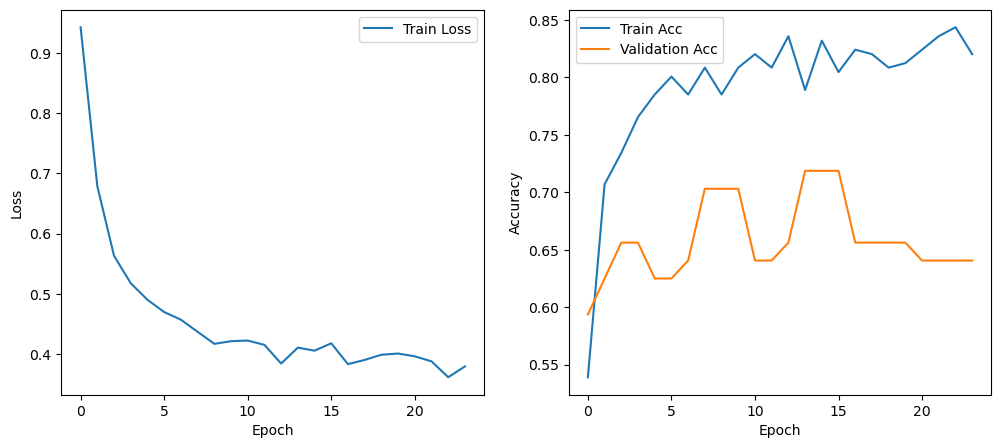

In [25]:
best_params = study.best_params

model = MLP(
    input_size=X_train.shape[1],
    hidden_size=[best_params["hidden_size_1"], best_params["hidden_size_2"]],
    output_size=len(set(y_train)),
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"]
)

# Set optimizer based on best selection
if best_params["optimizer"] == "SGD":
    model.optimizer = torch.optim.SGD(model.parameters(), lr=best_params["learning_rate"], momentum=0.9)
elif best_params["optimizer"] == "AdamW":
    model.optimizer = torch.optim.AdamW(model.parameters(), lr=best_params["learning_rate"])

# Data loaders with best batch size
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
                          batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)),
                        batch_size=best_params["batch_size"], shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)),
                         batch_size=best_params["batch_size"], shuffle=False)

# Train the final model
history = model.train_model(train_loader, val_loader, epochs=best_params["epochs"])

# Final evaluation on the test set
final_accuracy = model.evaluate(test_loader)
print(f"Final Test Accuracy with optimized parameters: {final_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Data Preprocessing
We have 2900 sets of time series data, each with 200 cells (per condition, so 2 x 200 = 400 cells if we count both) observed over 144 time points - it's essential to structure the data appropriately to capture both temporal and spatial dependencies. Concatenating all time series into a single sequence is generally not recommended, as it may introduce artificial dependencies between unrelated sequences. 

Instead, we load each CSV into a 3D NumPy array where each slice corresponds to one time series set.

In [3]:
import glob
import numpy as np
import pandas as pd

def load_data_into_3d_array(path_pattern):
    all_files = glob.glob(path_pattern)
    data_list = [pd.read_csv(file).values for file in all_files]
    data_array = np.stack(data_list, axis=0)
    return data_array

In [4]:
# Step 1: Load data
data = load_data_into_3d_array('../experiments/SSA_telegraph_model/var_v_accuracy_plot/data/mRNA_*/*.csv')
data.shape

(2900, 400, 145)

In [ ]:
data

In [6]:
# Step 2: Clean data
def clean_data(data):
    '''
    1. Replace Infinite Values and Handle Missing Data
    2. Remove Zero-Variance Features
    '''
    # Convert data to float to accommodate NaN values
    data = data.astype(float)
    # Replace infinite values with NaN
    data[np.isinf(data)] = np.nan
    # Handle missing data (e.g., interpolate or fill with mean)
    # Here, we fill NaN with the mean of each feature across time points (imputation methods can be complex so this is just a simple example)
    nan_mask = np.isnan(data)
    mean_values = np.nanmean(data, axis=2, keepdims=True)
    data[nan_mask] = np.take(mean_values, np.where(nan_mask)[2])

    # Calculate variance across time points for each feature
    variance = np.var(data, axis=2)
    # Identify features with non-zero variance
    non_zero_variance_mask = np.any(variance > 0, axis=0)
    # Select only features with non-zero variance
    return data[:, non_zero_variance_mask, :]

# Apply cleaning function
data = clean_data(data)

In [24]:
# Step 3: Split features/labels
X = data[:, 1:, :]
y = data[:, 0, :]
X.shape, y.shape

((2900, 399, 145), (2900, 145))

In [26]:
# Step 4: Normalize data
# Reshape data to 2D array for normalization
num_samples, num_features, num_time_points = X.shape
X_reshaped = X.reshape(-1, num_time_points)
# Initialize scaler
scaler = StandardScaler()
# Fit and transform data
X_normalized = scaler.fit_transform(X_reshaped)
# Reshape back to original 3D shape
X_normalized = X_normalized.reshape(num_samples, num_features, num_time_points)

In [27]:
# Step 5: Split data into training, validation, and test sets
# Flatten y to 1D if it's 2D with a single feature
# y = y.reshape(y.shape[0], -1)
# if y.shape[1] == 1:
#     y = y.flatten()

# Split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# Split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [13]:
y

(2900, 145)

In [ ]:
# Step 6: DataLoaders for PyTorch

def create_data_loader(X, y, batch_size=64, shuffle=True):
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    # Create TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)
    # Create DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

# Create DataLoaders
train_loader = create_data_loader(X_train, y_train, batch_size=64, shuffle=True)
val_loader = create_data_loader(X_val, y_val, batch_size=64, shuffle=False)
test_loader = create_data_loader(X_test, y_test, batch_size=64, shuffle=False)


Training the model

In [ ]:
set_seed(42)
# Assuming X_train has the shape (num_samples, num_features, num_time_steps)
num_features = X_train.shape[1]
num_time_steps = X_train.shape[2]
input_size = num_features * num_time_steps  # Flattened input size
output_size = len(set(y_train))  # Number of classes
hidden_size = [256, 64]
dropout_rate = 0.25
learning_rate = 0.001
epochs = 50
batch_size = 64
optimizer = 'Adam'

model = MLP(input_size, hidden_size, output_size, dropout_rate, learning_rate, optimizer=optimizer)
history = model.train_model(train_loader, val_loader, epochs=epochs, patience=10)

# Evaluate MLP model
mlp_accuracy = model.evaluate(test_loader)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.